# Importazione librerie

In [1]:
pip install mpl_finance


[notice] A new release of pip is available: 23.2 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [1]:
# -*- coding: utf-8 -*-
"""
Created on Sat Sep 17 17:01:08 2024

@author: Avv. Macco, Canola Gavioli, Giulio Falorsi
"""

import matplotlib.pylab as plt
import numpy as np
from tqdm import tqdm
from mpl_finance import candlestick_ohlc
import pandas as pd
import os
tqdm.pandas()

/Users/antonellomacco/miniconda3/envs/BaseEnv/lib/python3.10/site-packages/mpl_finance.py:16: DeprecationWarning: 



    Please use `mplfinance` instead (no hyphen, no underscore).

    To install: `pip install --upgrade mplfinance` 

   For more information, see: https://pypi.org/project/mplfinance/


  __warnings.warn('\n\n  ================================================================='+


# Definizione classi agenti

In [2]:
#RANDOM AGENT
class RandomAgent:
    def __init__(self,id,
                 **kwargs_random,
                 #gaussian_shift = 0.001,
                 #tipo = 'Random'
                 ):
        self.id=id
        self.name = kwargs_random['name']
        self.gain=0
        self.cash=0
        self.stock=0
        self.gaussian_shift = kwargs_random['gaussian_shift']

    def Action(self):

        decision= np.random.uniform()
        if(decision<=0.45):
            decision='Buy'
        elif(decision<0.9):
            decision='Sell'
        else:
            decision='Pass'
        return decision

    def Price(self, price, time_c):
        #la gaussiana è shiftata di 1/1000 il prezzo cosi non scende
        price_proposed = float(price) + np.random.normal(price*self.gaussian_shift, price/100)

        link=[np.round(price_proposed,2),
              self.id,
              time_c]

        return link

    
#TRADER AGENT MA
class TraderAgentMA:
    def __init__(self,id,
                 **kwargs_ma,
                 #min_period_ma=1,
                 #max_period_ma=200,
                 #tipo = 'TraderMA'
                 ):
        self.id=id
        self.name = kwargs_ma['name']
        self.gain=0
        self.cash=0
        self.stock=0
        self.period = 0
        self.min_period_ma = kwargs_ma['min_period_ma']
        self.max_period_ma = kwargs_ma['max_period_ma']
        self.interval_pass = kwargs_ma['interval_pass']

    def Action(self,
               **market_kwargs,
               #ohlc_, live_price
               ):
        ## estraggo il periodo
        ## calcolo MA(m)
        #estraggo i closes from ohlc
        data = [x[3] for x in market_kwargs['ohlc']]

        T = np.random.randint(self.min_period_ma, self.max_period_ma)
        self.period = T
        MovA = np.mean(data[-T:])
        price = data[-1]
        n = np.random.uniform(0,self.interval_pass)
        threshold_up_buy = MovA*(1+n)
        threshold_down_sell = MovA*(1-n)

        if (price > threshold_up_buy):
          decision = 'Buy'
        elif (price < threshold_down_sell):
          decision = 'Sell'
        else:
            decision='Pass'

        return decision

    def Price(self, price, decision, time_c):
        link = [price, self.id, time_c]
        if decision == 'Buy':
          link = [np.round(price + abs(np.random.normal(0,price/100)),2),
                  self.id,
                  time_c]
        if decision == 'Sell':
          link = [np.round(price - abs(np.random.normal(0,price/100)),2),
                  self.id,
                  time_c]

        return link


#TRADER AGENT BOLLINGER
class TraderAgentBB:
    def __init__(self,id,
                 **kwargs_bb,
                 #min_period_bb = 5,
                 #max_period_bb = 200,
                 #min_bb_dev = 0.5,
                 #max_bb_dev = 4,
                 #tipo = 'TraderBB'
                 ):

        self.id=id
        self.name = kwargs_bb['name']
        self.gain=0
        self.cash=0
        self.stock=0
        self.std=0
        self.period=0
        self.min_period_bb = kwargs_bb['min_period_bb']
        self.max_period_bb = kwargs_bb['max_period_bb']
        self.min_bb_dev = kwargs_bb['min_bb_dev']
        self.max_bb_dev = kwargs_bb['max_bb_dev']

    def Action(self,
               **market_kwargs,
               #ohlc_, live_price
               ):


        #estraggo i closes from ohlc

        data = [x[3] for x in market_kwargs['ohlc']]

        ## estraggo s = deviazioni delle bande BB
        s = np.random.uniform(self.min_bb_dev, self.max_bb_dev)
        ## estraggo il periodo delle BB
        T = np.random.randint(self.min_period_bb, self.max_period_bb)
        self.std = s
        self.period = T

        price = data[-1]

        #calcolo le BB up e down
        BBup = np.mean(data[-T:]) + s*np.std(data[-T:])
        BBdown = np.mean(data[-T:]) - s*np.std(data[-T:])

        if (price > BBup):
          #print(f'{price} (price) > {BBup} (BBup) --> Sell')
          decision = 'Sell'
        elif (price < BBdown):
          #print(f'{price} (price) < {BBdown} (BBdown) --> Buy')
          decision = 'Buy'
        else:
            decision='Pass'
        return decision

    def Price(self, price, decision, time_c):

        link = [self.id, price, time_c]
        if decision == 'Buy':
          link = [np.round(price + abs(np.random.normal(0,price/100)),2),
                  self.id,
                  time_c]
        if decision == 'Sell':
          link = [np.round(price - abs(np.random.normal(0,price/100)),2),
                  self.id,
                  time_c]

        return link



#TRADER AGENT BOLLINGER
class CopyAgent:
    def __init__(self,id,
                 **kwargs_copy,
                 ):

        self.id=id
        self.name = kwargs_copy['name']
        self.gain=0
        self.cash=0
        self.stock=0

        self.min_copied_agents = kwargs_copy['min_copied_agents']
        self.max_copied_agents = kwargs_copy['max_copied_agents']
        self.min_copied_period = kwargs_copy['min_copied_period']
        self.max_copied_period = kwargs_copy['max_copied_period']

    def Action(self,
               **market_kwargs,
               ):

        copied_agents = int(np.random.randint(self.min_copied_agents, self.max_copied_agents))
        copied_period = int(np.random.randint(self.min_copied_period, self.max_copied_period))

        agents_info = market_kwargs['agents_info']


        for key,info in agents_info.items():

          info['score'] = (info['gain_hst'][-1] - info['gain_hst'][-copied_period])/(info['gain_hst'][-copied_period] + 0.00001)

        best_agent_id_score = sorted([(k,info['score']) for k,info in agents_info.items() if info['tipo'].lower() != 'copy_trader' ], key=lambda x: x[1], reverse = True)[:copied_agents]
        best_agent_id = [x[0] for x in best_agent_id_score]

        strategies_2copy = [agents_info[i]['last_action'] for i in best_agent_id]

        decision = max(set(strategies_2copy), key=strategies_2copy.count)

        return decision

    def Price(self, price, decision, time_c):

        link = [self.id, price, time_c]
        if decision == 'Buy':
          link = [np.round(price + abs(np.random.normal(0,price/100)),2),
                  self.id,
                  time_c]
        if decision == 'Sell':
          link = [np.round(price - abs(np.random.normal(0,price/100)),2),
                  self.id,
                  time_c]

        return link

# Funzioni 2.0

In [3]:
### DEFINIZIONE AGENTI ###

# FUNZIONE NUOVA #

def initialize_agents2(agents_type_dic,
                       seed = 'random', shuffle = False):

  agents_source = [ item for items in [[k]*agents_type_dic[k]['how_many'] for k in agents_type_dic.keys()] for item in items ]
  agents = []
    
  for i,k in enumerate(agents_source):
    A=agents_type_dic[k]['type'](i,**agents_type_dic[k])
    agents.append(A)

  if seed == 'random':
    seed = np.random.randint(0,2**31)
  np.random.seed(seed)

  if shuffle:
    np.random.shuffle(agents)
    return agents, seed

  else:
    return agents


#### FUNZIONE DELLA SIMULAZIONE ###

def asmt_simulation2(agents,
                    n_step_init = 200,
                    n_step_simulation = 1000,
                    initial_price = 100,
                    verb = 0,
                    seed = 'random',
                    tqdm_bar_desc = '',
                    tqdm_bar_on = True,
                    ):


  if seed == 'random':
    seed = np.random.randint(0,2**31)

  #set seed
  np.random.seed(seed)

  c=0   #contatore temporale

  price = initial_price
  final_price = initial_price

  agents_name = list(set([a.name for a in agents]))

  volumes = {f'volume_{an}':[0]*(n_step_simulation+n_step_init) for an in agents_name}
  gains = {f'gain_{an}':[0]*(n_step_simulation+n_step_init) for an in agents_name}

  agents_info = {ag.id:{'gain_hst':[],'last_action':None,'tipo':ag.name } for ag in agents}

  highs = []
  lows = []
  opens = []
  closes = []

  iterator = range(n_step_simulation + n_step_init)
  if tqdm_bar_on:
    iterator = tqdm(range(n_step_simulation + n_step_init), position=0,leave=True, desc=tqdm_bar_desc)

  for k in iterator:

    # la history OHLC fino ad ora zippata
    ohlc = list(zip(opens,highs,lows,closes))
    printv(f'ohlc: {ohlc}',0,verb)
    market_kwargs = {'ohlc':ohlc,
                     'agents_info':agents_info}

    opens.append(price)
    high = price
    low = price

    c = 0  #contatore temporale per filling ordine resettato dopo ogni step
    np.random.shuffle(agents) #shuffle indici agenti sennò i primi sono avvantaggiati perché agiscono sempre prima

    queueB=[] #bids
    queueS=[] #asks

    decision = 'Pass'
    price_new = price

    for i,agent in enumerate(agents):

      ## RANDOM AGENTS ##
      if(agent.name.lower() == 'random'):
        decision = agent.Action()
        agents_info[agent.id]['last_action'] = decision
        price_new = agent.Price(price, c)

        printv(f'agente n. {i} id {agent.id} {agent.name} {decision} at {price_new[0]}',0,verb)
        printv(f'queueB:\n{queueB}\nqueueS:\n{queueS}',2,verb)


      ## GLI ALTRI DOPO N_STEP_INIT
      elif (k > n_step_init):
        decision = agent.Action(**market_kwargs)
        agents_info[agent.id]['last_action'] = decision
        price_new = agent.Price(price, decision, c)


        printv(f'agente n. {i} id {agent.id} {agent.name} {decision} at {price_new[0]}',0,verb)
        printv(f'queueB:\n{queueB}\nqueueS:\n{queueS}',2,verb)


      ## SE BUY O SELL AGISCO SEMPRE ALLO STESSO MODO PER OGNI TIPO DI AGENTE ##

      if(decision=='Buy'):
          queueB.append(price_new)
          queueB.sort()
          volumes[f'volume_{agent.name}'][k] += 1
          c+=1

      elif(decision=='Sell'):
          queueS.append(price_new)
          queueS.sort()
          volumes[f'volume_{agent.name}'][k] -= 1
          c+=1

      ## ORDERS MATCHING ##
      if(len(queueB)!=0 and len(queueS)!=0):

        # li ordino dal minore al maggiore
        queueB.sort()
        queueS.sort()
        printv(f'queueB:\n{queueB}\nqueueS:\n{queueS}',2,verb)
        # il più piccolo ask
        ask = queueS[0][0]
        bids = np.array(queueB)[:,0]

        # se c'è almeno un bid maggiore del più piccolo ask allora prendo il più piccolo ask
        if (bids > ask).sum() > 0:

          bid = bids[bids > ask][0]

          #agente buyer
          idx_buyer = np.arange(len(bids))[bids > ask][0]

          id_buyer = queueB[idx_buyer][1] # id dell'agente

          # si deve trovare l'indice di lista di agents ha id j_b
          j_b = [i for i,a in enumerate(agents) if a.id == id_buyer][0]

          time_buy = queueB[idx_buyer][2]

          #agente seller
          id_seller = queueS[0][1]
          j_s = [i for i,a in enumerate(agents) if a.id == id_seller][0]
          time_sell = queueS[0][2]

          if (time_sell > time_buy):  #se l'ordine di vendita viene immesso dopo quello di comprare, il prezzo finale è quello del bid
            final_price = bid
          else:
            final_price = ask #altrimenti è quello di ask

          #compra al prezzo di ask anche se ha chiesto di comprare al prezzo di bid più alto
          agents[j_b].cash -= final_price
          agents[j_b].stock += 1
          printv(f'agente n. {j_b} id {agents[j_b].id} {agents[j_b].name} cash {agents[j_b].cash} stock {agents[j_b].stock}',2,verb)

          # vende al prezzo di ask che ha detto lui (sempre il più basso)
          agents[j_s].cash += final_price
          agents[j_s].stock -= 1
          printv(f'agente n. {j_s} id {agents[j_s].id} {agents[j_s].name} cash {agents[j_s].cash} stock {agents[j_s].stock}',2,verb)

          printv(f'MATCHING: agente n. {j_b} id {agents[j_b].id} {agents[j_b].name} buy - agente n.{j_s} id {agents[j_s].id} {agents[j_s].name}  sell: at {final_price}',2,verb)

          queueB.remove(queueB[idx_buyer])
          queueS.remove(queueS[0])
          price = final_price

          # cerco massimi e minimi della candela
          if final_price > high:
            high = final_price
          if final_price < low:
            low = final_price

    # compute profit for each agents
    for i,agent in enumerate(agents):
        agent.gain = agent.cash + (final_price * agent.stock)
        agents_info[agent.id]['gain_hst'].append(agent.gain)
        printv(f'agente n. {i} id {agent.id} {agent.name} cash {agent.cash} stock {agent.stock} gain {agent.gain}',2,verb)

    # compute average profit at each timestep for each type of agents

    for ag_name in agents_name:
      avg_gain = np.array([agent.gain for agent in agents if (agent.name == ag_name)]).mean()
      gains[f'gain_{ag_name}'][k] = avg_gain

    #Aggiornamento candela

    closes.append(price)
    highs.append(high)
    lows.append(low)

  ohlc = [(i, opens[i], highs[i], lows[i], closes[i]) for i in range(len(closes))]

  out = {'ohlc': ohlc,
        'agents':agents,
        'seed':seed}

  out.update(gains)
  out.update(volumes)
  out.update({'agents_info': agents_info})

  

  return out

def printv(out,threshold,verbosity):
  if verbosity > threshold:
    print(out)
    
def parse_str_row(row):
    
    out = row
    
    try:
        out = np.array(row.replace("[", "").replace("]", "").split(",")).astype(float)
        
    except:
        pass
    
    return out

# Simulazione solo random

In [202]:
how_many_random = 50

agents_type_dic = {
                   'random':{'gaussian_shift': 0.00051,
                             'how_many': how_many_random,
                             'name':'random',
                             'type':RandomAgent},
                   }
agents_type_dic

{'random': {'gaussian_shift': 0.00051,
  'how_many': 50,
  'name': 'random',
  'type': __main__.RandomAgent}}

In [217]:
# no shuffle agenti all'inizio
shuffle = False

#simulation params
n_step_init = 250
n_step_simulation = 500
initial_price = 100
verb = 0
#seed_simu = 'random'

n_simulations = 100
seeds = ['random']*n_simulations

outs_simulation = []

for i,seed in tqdm(enumerate(seeds), position=0,leave=True, total = n_simulations):

    # initialize agents #
    agents = initialize_agents2(agents_type_dic, shuffle=shuffle)

    # print agents type frequency
    #print(pd.Series([a.name for a in agents]).value_counts(),'\n')
    agents_name = list(set([a.name for a in agents]))

    ## SIMULAZIONE ##

    out_simulation = asmt_simulation2(agents,
                                    n_step_init = n_step_init,
                                    n_step_simulation = n_step_simulation,
                                    initial_price = initial_price,
                                    verb = verb,
                                    seed = seed,
                                    tqdm_bar_desc = f'simu_{i}',
                                    tqdm_bar_on = False)

    outs_simulation.append(out_simulation)

avg_gain_agents = {f'avg_gain_{name}':np.array([np.array(d[f'gain_{name}']) for d in outs_simulation]).mean(axis=0) for name in agents_name}
std_gain_agents = {f'std_gain_{name}':np.array([np.array(d[f'gain_{name}']) for d in outs_simulation]).std(axis=0) for name in agents_name}
seeds = [o['seed'] for o in outs_simulation]


avg_ohlc = np.array([[np.array(x[1:]).mean() for x in outs_simulation[k]['ohlc']] for k in range(len(outs_simulation))])
last_values = avg_ohlc[:,-1]
print(last_values)
print((last_values - initial_price).mean(), (last_values - initial_price).std())

100%|█████████████████████████████████████████| 100/100 [01:41<00:00,  1.01s/it]

[152.6475  51.0225 124.8375 141.055   79.2375  53.0075 104.6775 107.52
  15.2825  59.4275 174.175   44.935  102.7075  66.11    64.1425 187.0475
  65.035   68.5075  75.9525 260.98    31.805  177.25    49.835   53.7175
 123.07    54.125   97.2925  57.205   53.425   59.67   110.62   148.5975
 100.775  110.46    90.0725  26.04    46.      97.825  160.6075  68.2775
  86.045   74.4625  64.8575 109.1925  95.14   151.9975  96.2825  85.0075
  81.8    139.52    37.4325 113.785   43.32   125.4575  27.9875  70.9875
 154.44    41.145  118.905   92.64    17.0175 105.5975 146.7525 157.35
 102.7125 138.4925  47.435  129.505   91.505  310.275   36.27   129.4375
  48.26    13.975   65.01    29.97   115.445  102.055  207.135   69.7075
  72.3125 144.9425  83.2975  48.7725 588.     187.4275  70.7725  35.44
  95.435   95.135  175.6225  26.43     6.6475 194.865   44.2825  72.6975
  28.695   64.605   77.1875 103.8625]
-1.942800000000002 72.43909453230347


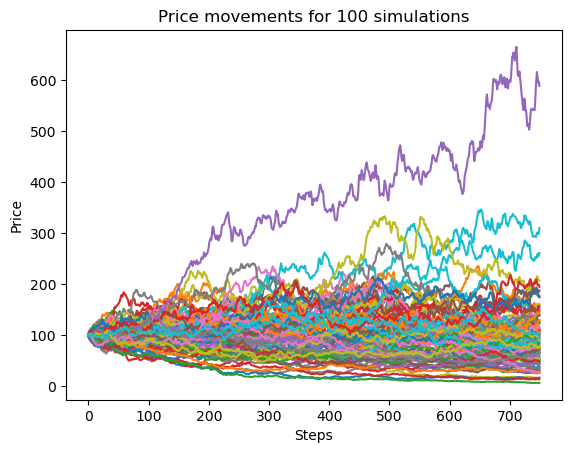

In [224]:
plt.plot(avg_ohlc.T)
plt.xlabel('Steps')
plt.ylabel('Price')
plt.title('Price movements for 100 simulations')
plt.show()

In [261]:
std = avg_ohlc.std(axis=0)
x = np.arange(len(std))
y = std
coefficients = np.polyfit(x, y, 0.5)
coefficients

array([47.93934494])

In [265]:
pcov

array([[inf, inf, inf],
       [inf, inf, inf],
       [inf, inf, inf]])

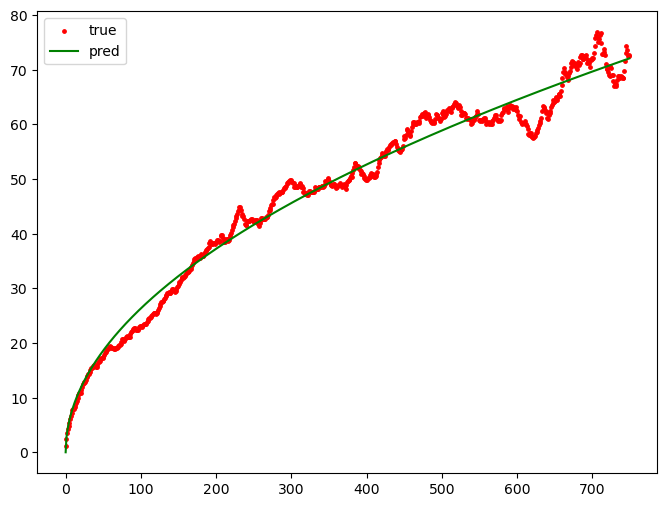

In [277]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def func(x,a,b,c):
    return a * np.sqrt(x)

y = func(x,2,-2,3)
y_true = std

popt, pcov = curve_fit(func,x,y_true)
y_pred = func(x,*popt)

fig,ax = plt.subplots(figsize=(8,6))
ax.scatter(x,y_true,c='r',label='true',s=6)
ax.plot(x,y_pred,c='g',label='pred')
ax.legend(loc='best')


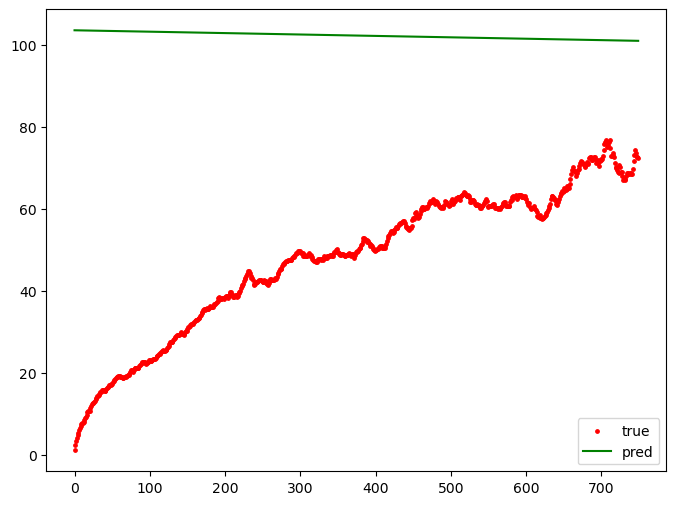

In [273]:
def func(x,a,b,c):
    return a * x + b

y = func(x,2,-2,3)
mean = avg_ohlc.mean(axis=0)

popt, pcov = curve_fit(func,x,mean)
mean_pred = func(x,*popt)

fig,ax = plt.subplots(figsize=(8,6))
ax.scatter(x,y_true,c='r',label='true',s=6)
ax.plot(x,mean_pred,c='g',label='pred')
ax.legend(loc='best')

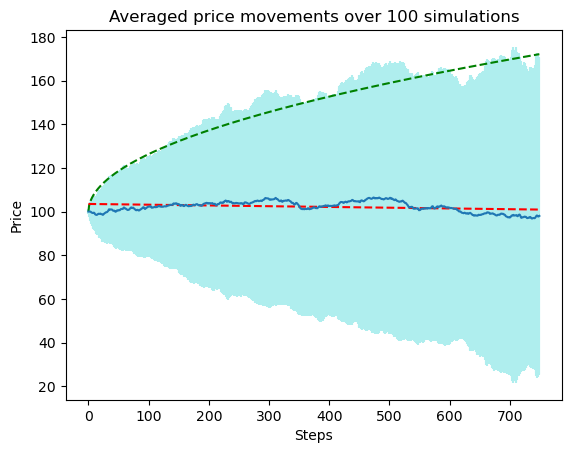

In [282]:
std = avg_ohlc.std(axis=0)
x = np.arange(len(std))
y = std
coefficients = np.polyfit(x, y, 0.5)
m = coefficients[0]
#plt.plot(x, m * np.array(x)**0.5, label=f'Regression line: $\sigma^2$ ~ {m:.2f}t', color='paleturquoise', linestyle='--')
plt.errorbar(np.arange(750), avg_ohlc.mean(axis=0), avg_ohlc.std(axis=0),ecolor='paleturquoise' )
plt.xlabel('Steps')
plt.ylabel('Price')
plt.title('Averaged price movements over 100 simulations')
plt.plot(x,y_pred+100,c='g',label='pred', linestyle='--')
#plt.plot(x,-y_pred+100,c='g',label='pred', linestyle='--')
plt.plot(x,mean_pred,c='r',label='pred', linestyle='--')
plt.show()

In [221]:
import seaborn as sns

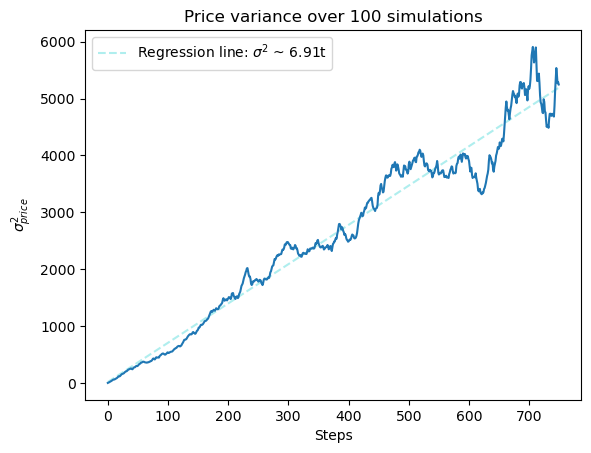

In [243]:
var = avg_ohlc.var(axis=0)
x = np.arange(len(var))
y = var
coefficients = np.polyfit(x, y, 1)
m, q = coefficients
plt.plot(x, m * np.array(x) + q, label=f'Regression line: $\sigma^2$ ~ {m:.2f}t', color='paleturquoise', linestyle='--')
plt.xlabel('Steps')
plt.ylabel('$\sigma^2_{price}$')
plt.plot(var)
plt.legend(loc=0)
plt.title('Price variance over 100 simulations')
plt.show()
#plt.scatter(x=np.arange(len(std)), y=std, marker='.')

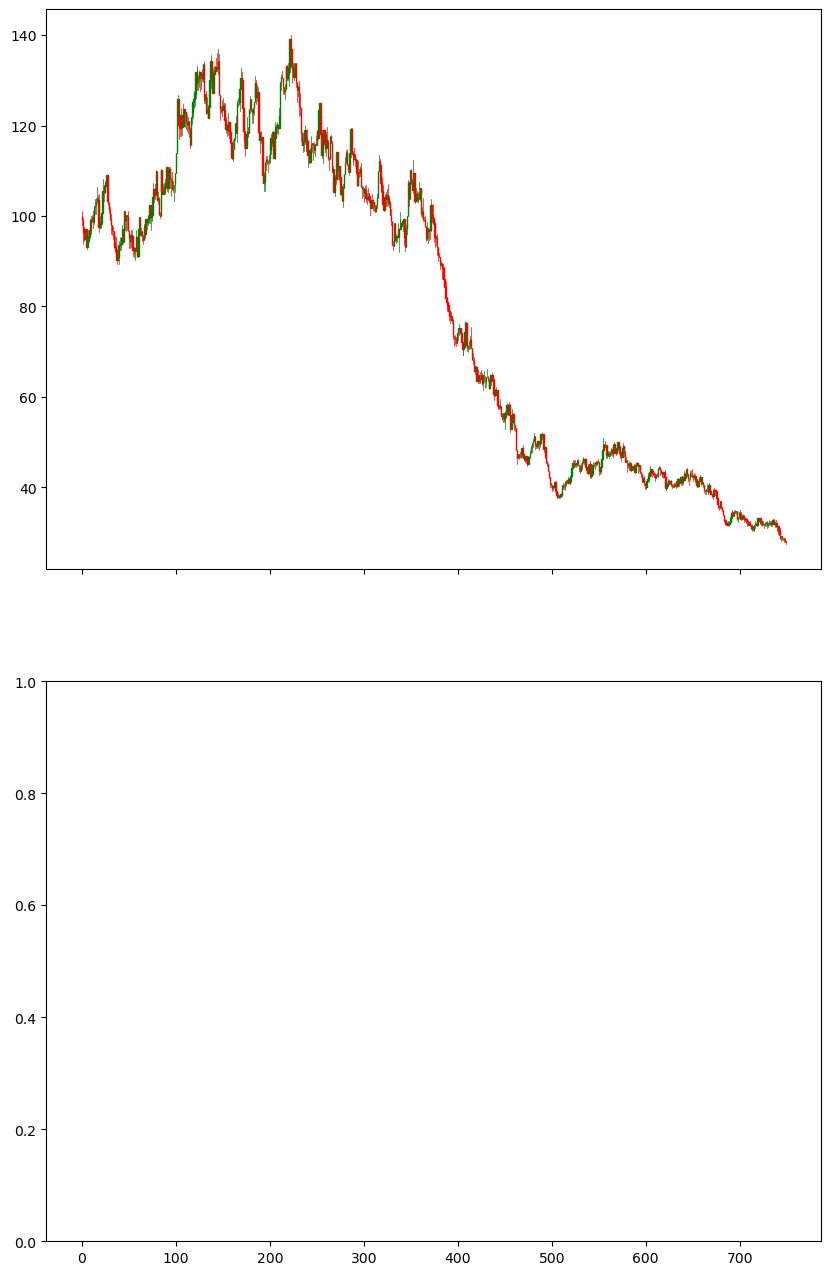

In [10]:
k = 1

# Crea una figura e un oggetto axes
fig, axs = plt.subplots(2, 1, figsize = (10,16), sharex=True)

# Utilizza la libreria candlestick_ohlc per creare il grafico a candela
candlestick_ohlc(axs[0], outs_simulation[k]['ohlc'], width=0.6, colorup='g', colordown='r')


plt.show()

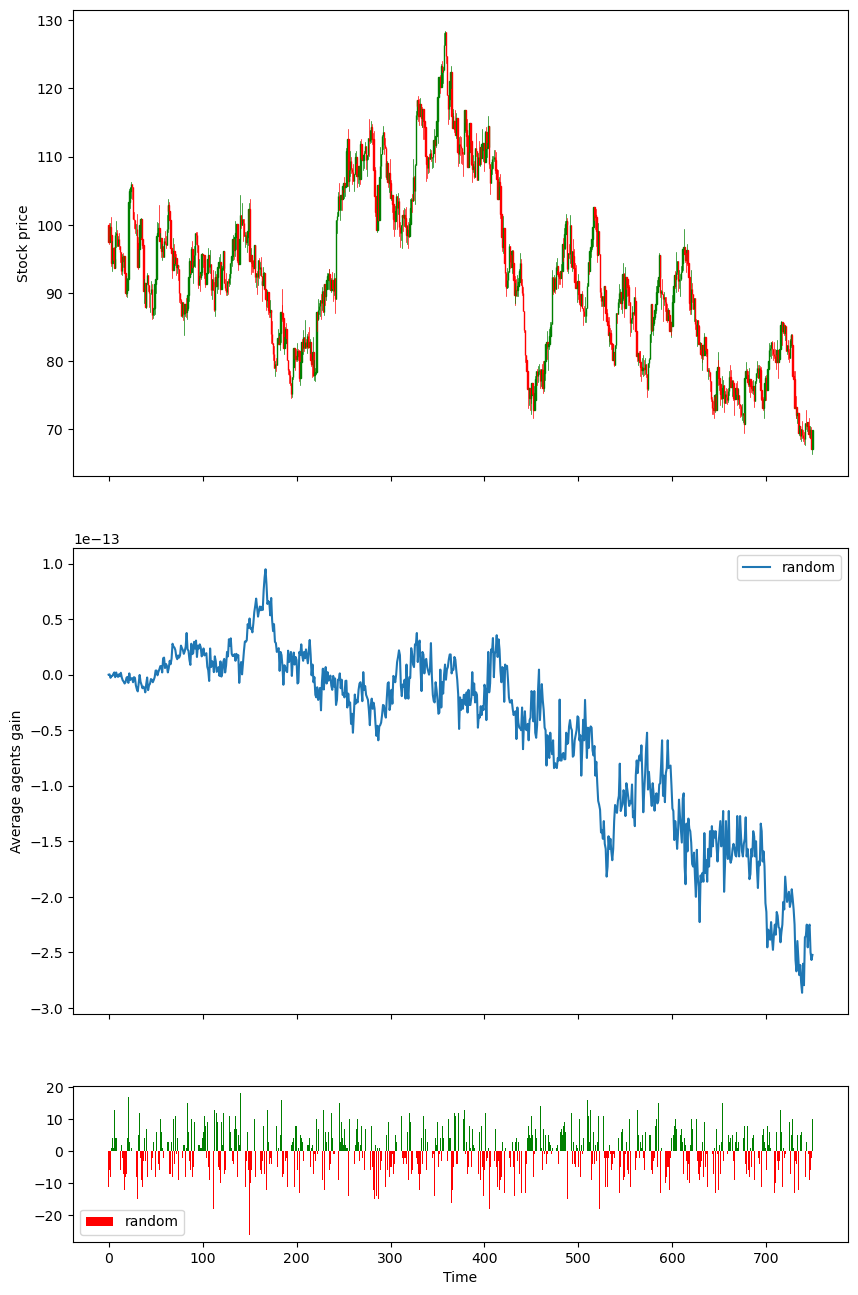

In [11]:
# PLOT STOCK AND LOG VARIANCE OF RANDOMS ##

# Crea una figura e un oggetto axes
fig, axs = plt.subplots(len(agents_name)+2, 1, figsize = (10,16), sharex=True, gridspec_kw={'height_ratios': [3,3] + [1]*len(agents_name)})

# Utilizza la libreria candlestick_ohlc per creare il grafico a candela
candlestick_ohlc(axs[0], out_simulation['ohlc'], width=0.6, colorup='g', colordown='r')

for i,ag_name in enumerate(agents_name):
    
    axs[1].plot(out_simulation[f'gain_{ag_name}'], label = ag_name)

    color = ['r' if x<0 else 'g' for x in out_simulation[f'volume_{ag_name}']]

    axs[i+2].bar(np.arange(len(out_simulation[f'volume_{ag_name}'])), out_simulation[f'volume_{ag_name}'],
               color=color, label = ag_name)

    axs[i+2].legend(loc=0)

axs[1].legend(loc=0)

axs[len(agents_name)+1].set_xlabel('Time')
axs[0].set_ylabel('Stock price')
axs[1].set_ylabel('Average agents gain')

#plt.savefig('stock_price_10_3_3.png')
plt.show()

# Simulazione (prova con longT e dayT agents)

In [110]:
def compute_trans_point(df):

    df['MA_BB_proportion'] = (df['traderMA_how_many'] ) / (df['traderBB_how_many'])

    min_positive_gain_ma_index = df[df['final_gain_traderMA'] > 0]['MA_BB_proportion'].sort_values().index[0]
    max_negative_gain_ma_index = df[df['final_gain_traderMA'] < 0]['MA_BB_proportion'].sort_values().index[-1]
    trans_point_ma = (df.loc[max_negative_gain_ma_index]['MA_BB_proportion'] + df.loc[min_positive_gain_ma_index]['MA_BB_proportion'])/2

    max_positive_gain_bb_index = df[df['final_gain_traderBB'] > 0]['MA_BB_proportion'].sort_values().index[-1]
    min_negative_gain_bb_index = df[df['final_gain_traderBB'] < 0]['MA_BB_proportion'].sort_values().index[0]
    trans_point_bb = (df.loc[min_negative_gain_bb_index]['MA_BB_proportion'] + df.loc[max_positive_gain_bb_index]['MA_BB_proportion'])/2

    err_trans_point_ma = np.abs((df.loc[max_negative_gain_ma_index]['MA_BB_proportion'] - df.loc[min_positive_gain_ma_index]['MA_BB_proportion'])/2)
    err_trans_point_bb = np.abs((df.loc[min_negative_gain_bb_index]['MA_BB_proportion'] - df.loc[max_positive_gain_bb_index]['MA_BB_proportion'])/2)
    
    return trans_point_ma, trans_point_bb, err_trans_point_ma, err_trans_point_bb


def compute_trans_point1(df):

    df['MA_BB_proportion'] = (df['traderMA_how_many'] ) / (df['traderBB_how_many'])
    
    max_negative_gain_ma_index = df[df['final_gain_traderMA'] < 0]['MA_BB_proportion'].sort_values().index[-1]
    min_positive_gain_ma_index = max_negative_gain_ma_index - 1
    
    trans_point_ma = (df.loc[max_negative_gain_ma_index]['MA_BB_proportion'] + df.loc[min_positive_gain_ma_index]['MA_BB_proportion'])/2

    max_positive_gain_bb_index = df[df['final_gain_traderBB'] > 0]['MA_BB_proportion'].sort_values().index[-1]
    min_negative_gain_bb_index = df[df['final_gain_traderBB'] < 0]['MA_BB_proportion'].sort_values().index[0]
    trans_point_bb = (df.loc[min_negative_gain_bb_index]['MA_BB_proportion'] + df.loc[max_positive_gain_bb_index]['MA_BB_proportion'])/2

    err_trans_point_ma = np.abs((df.loc[max_negative_gain_ma_index]['MA_BB_proportion'] - df.loc[min_positive_gain_ma_index]['MA_BB_proportion'])/2)
    err_trans_point_bb = np.abs((df.loc[min_negative_gain_bb_index]['MA_BB_proportion'] - df.loc[max_positive_gain_bb_index]['MA_BB_proportion'])/2)
    
    return trans_point_ma, trans_point_bb, err_trans_point_ma, err_trans_point_bb


In [111]:
max_negative_gain_ma_index = df_bb_plot[df_bb_plot['final_gain_traderMA'] < 0]['MA_BB_proportion'].sort_values().index[-1]

#print(df_bb_plot[df_bb_plot['final_gain_traderMA'] < 0]['MA_BB_proportion'].sort_values())

#df_bb_plot['MA_BB_proportion'].sort_values()

NameError: name 'df_bb_plot' is not defined

In [112]:
file_name = 'simulation_data_ma_vs_bb_new_new.csv'

#file_name = 'prova.csv'

cols = ['n_sim','n_step_init','n_step_sim','seeds']

#if csv file not exists create it
if not os.path.exists(file_name):
    df = pd.DataFrame(columns = cols)
    df.to_csv(file_name, index=False)
    print(f'created {file_name}')

    
else:
    df = pd.read_csv(file_name)
    print(f'readed {file_name}')
    
display(df)

readed simulation_data_ma_vs_bb_new_new.csv


,n_sim,n_step_init,n_step_sim,seeds,traderBB_min_period_bb,traderBB_max_period_bb,traderBB_min_bb_dev,traderBB_max_bb_dev,traderBB_name,traderBB_type,...,random_gaussian_shift,random_how_many,random_name,random_type,avg_gain_random,avg_gain_traderMA,std_gain_random,std_gain_traderMA,avg_gain_traderBB,std_gain_traderBB
0,10,250,500,"[196523772, 944433611, 1397302494, 1635953312,...",7.0,200.0,0.5,2.000000,traderBB,<class '__main__.TraderAgentBB'>,...,0.00053,50.0,random,<class '__main__.RandomAgent'>,"[-2.842170943040401e-16, -9.379164112033323e-1...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.2323359549485986e-15, 2.4941568232678516e-1...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",NaN,NaN
1,10,250,500,"[196523772, 944433611, 1397302494, 1635953312,...",7.0,200.0,0.5,2.000000,traderBB,<class '__main__.TraderAgentBB'>,...,0.00053,50.0,random,<class '__main__.RandomAgent'>,"[-2.842170943040401e-16, -9.379164112033323e-1...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.2323359549485986e-15, 2.4941568232678516e-1...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,10,250,500,"[196523772, 944433611, 1397302494, 1635953312,...",7.0,200.0,0.5,2.000000,traderBB,<class '__main__.TraderAgentBB'>,...,0.00053,50.0,random,<class '__main__.RandomAgent'>,"[-2.842170943040401e-16, -9.379164112033323e-1...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.2323359549485986e-15, 2.4941568232678516e-1...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,10,250,500,"[196523772, 944433611, 1397302494, 1635953312,...",7.0,200.0,0.5,2.000000,traderBB,<class '__main__.TraderAgentBB'>,...,0.00053,50.0,random,<class '__main__.RandomAgent'>,"[-2.842170943040401e-16, -9.379164112033323e-1...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.2323359549485986e-15, 2.4941568232678516e-1...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,10,250,500,"[196523772, 944433611, 1397302494, 1635953312,...",7.0,200.0,0.5,2.000000,traderBB,<class '__main__.TraderAgentBB'>,...,0.00053,50.0,random,<class '__main__.RandomAgent'>,"[-2.842170943040401e-16, -9.379164112033323e-1...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.2323359549485986e-15, 2.4941568232678516e-1...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2290,10,250,500,"[718631942, 2057737309, 1540933433, 1662655766...",7.0,200.0,0.5,3.125688,traderBB,<class '__main__.TraderAgentBB'>,...,0.00053,50.0,random,<class '__main__.RandomAgent'>,"[-3.410605131648481e-16, -2.8421709430403996e-...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[2.3047886012038013e-15, 3.3495439766209045e-1...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2291,10,250,500,"[718631942, 2057737309, 1540933433, 1662655766...",7.0,200.0,0.5,3.125688,traderBB,<class '__main__.TraderAgentBB'>,...,0.00053,50.0,random,<class '__main__.RandomAgent'>,"[-3.410605131648481e-16, -2.8421709430403996e-...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[2.3047886012038013e-15, 3.3495439766209045e-1...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2292,10,250,500,"[718631942, 2057737309, 1540933433, 1662655766...",7.0,200.0,0.5,3.125688,traderBB,<class '__main__.TraderAgentBB'>,...,0.00053,50.0,random,<class '__main__.RandomAgent'>,"[-3.4106051316

In [113]:
df = pd.read_csv(file_name)

# parametri fissi degli agenti

how_many_traders = 5
how_many_random = 5
n_classes = 2
min_period_bb = 7 
max_period_bb = 200
min_bb_dev = 0.5 #np.random.uniform(0.25,1)
max_bb_dev = 2 #np.random.uniform(min_bb_dev_long+0.01, 4)
min_period_ma = 7 #np.random.randint(25,100)
max_period_ma = 200 #np.random.randint(min_period_ma_long+1, 250)
gaussian_shift = 0.00053

#simulation params

shuffle = False
n_step_init = 250
n_step_simulation = 500
initial_price = 100
verb = 0
n_simulations = 3
seeds = ['random']*n_simulations

class1_size = np.arange(how_many_traders+1)
class2_size = how_many_traders - class1_size

while True:
    
    df = pd.read_csv(file_name)

    # samplo interval pass (parametro variabile)
    interval_pass = random.uniform(0,1)
    #max_bb_dev = random.uniform(min_bb_dev+0.01, 4)
    
    for n_ma,n_bb in tqdm(zip(class1_size, class2_size), position=0,leave=True,
                        total = len(class1_size),
                        desc = f'interval_pass: {interval_pass:.2f} max_bb_dev: {max_bb_dev:.2f}'):
        

        agents_type_dic = {'traderBB':{'min_period_bb':min_period_bb,
                                             'max_period_bb':max_period_bb,
                                             'min_bb_dev':min_bb_dev,
                                             'max_bb_dev':max_bb_dev,
                                             'name':'traderBB',
                                             'type':TraderAgentBB,
                                             'how_many':n_ma},

                           'traderMA':{'min_period_ma':min_period_ma,
                                             'max_period_ma':max_period_ma,
                                             'name':'traderMA',
                                             'interval_pass':interval_pass,
                                             'type':TraderAgentMA,
                                             'how_many':n_bb},

                           'random':{'gaussian_shift':gaussian_shift,
                                     'how_many': how_many_random,
                                     'name':'random',
                                     'type':RandomAgent},

                           }
        

        outs_simulation = []
            
        for i,seed in enumerate(seeds):

            # initialize agents #
            agents = initialize_agents2(agents_type_dic, shuffle=shuffle)

            # print agents type frequency
            #print(pd.Series([a.name for a in agents]).value_counts(),'\n')
            agents_name = list(set([a.name for a in agents]))

            ## SIMULAZIONE ##

            out_simulation = asmt_simulation2(agents,
                                            n_step_init = n_step_init,
                                            n_step_simulation = n_step_simulation,
                                            initial_price = initial_price,
                                            verb = verb,
                                            seed = seed,
                                            tqdm_bar_desc = f'simu_{i}',
                                            tqdm_bar_on = False)

            outs_simulation.append(out_simulation)

        avg_gain_agents = {f'avg_gain_{name}':np.array([np.array(d[f'gain_{name}']) for d in outs_simulation]).mean(axis=0) for name in agents_name}
        std_gain_agents = {f'std_gain_{name}':np.array([np.array(d[f'gain_{name}']) for d in outs_simulation]).std(axis=0) for name in agents_name}
        seeds = [o['seed'] for o in outs_simulation]

        data = { 'n_sim': [n_simulations],
                 'n_step_init': [n_step_init] ,
                 'n_step_sim': [n_step_simulation],
                 'seeds':[seeds],
                                  }

        input_p = {}
        [input_p.update({f'{k}_{k1}':[v1] for k1,v1 in v.items()}) for k,v in agents_type_dic.items()]

        data.update(input_p)
        data.update({k:[list(v)] for k,v in avg_gain_agents.items()})
        data.update({k:[list(v)] for k,v in std_gain_agents.items()})

        # nuova riga da appendere al df
        df_new_row = pd.DataFrame(data)
        #appendo al df e salvo
        df = pd.concat([df, df_new_row], ignore_index = True)
        
    df.to_csv(file_name, index=False)

NameError: name 'random' is not defined

In [114]:
## Analizzo il dataframe

In [115]:
columns = [c for c in df.columns if (('avg_gain' in c) or ('std_gain' in c))]

for col in columns:
    agent = col.replace('std_gain_', '').replace('avg_gain_', '')
    df[col] = df[col].apply(lambda x : parse_str_row(x))
    if 'avg_gain_' in col:
        df[f'final_gain_{agent}'] = df[col].progress_apply(lambda x : x if np.isnan(x).all() else x[-1])
        
    if 'std_gain_' in col:
        df[f'final_std_{agent}'] = df[col].progress_apply(lambda x : x if np.isnan(x).all() else x[-1])        

100%|███████████████████████████████████| 2295/2295 [00:00<00:00, 441515.81it/s]


In [116]:
cols_groupby = ['traderBB_min_period_bb','traderBB_max_period_bb', 'traderBB_min_bb_dev',
                'traderBB_max_bb_dev','traderMA_min_period_ma', 'traderMA_max_period_ma',
                'traderMA_interval_pass', 'random_gaussian_shift',]

df_trans = pd.DataFrame()

for j,(i,df_group) in enumerate(df.groupby(cols_groupby)):
    
    trans_point_ma, trans_point_bb, err_trans_point_ma, err_trans_point_bb = compute_trans_point1(df_group)
    row = df_group[cols_groupby].copy().drop_duplicates().iloc[0]
    row['trans_point_ma'] = trans_point_ma
    row['trans_point_bb'] = trans_point_bb
    row['err_trans_point_ma'] = err_trans_point_ma
    row['err_trans_point_bb'] = err_trans_point_bb
    
    df_trans = df_trans.append(row, ignore_index=True)

AttributeError: 'DataFrame' object has no attribute 'append'

In [120]:
df_trans.columns

In [121]:
df_interval_pass = df_trans[df_trans['traderBB_max_bb_dev'] == 2.0].copy()
df_max_bb = df_trans[df_trans['traderMA_interval_pass'] == 0.1].copy()

In [122]:
plt.figure(figsize=(8,6))

plt.errorbar(df_interval_pass['traderMA_interval_pass'],df_interval_pass['trans_point_ma'],
             df_interval_pass['err_trans_point_ma'], fmt='.', capsize=3, markersize=7)

plt.title('MA/BB critical point vs interval pass')
plt.xlabel('interval pass')
plt.ylabel('MA/BB critical point')

plt.show()

KeyError: 'trans_point_ma'

<Figure size 800x600 with 0 Axes>

In [ ]:
df_interval_pass.sort_values(by='err_trans_point_ma')[['err_trans_point_ma','trans_point_ma','traderMA_interval_pass']]
#df_max_bb['err_trans_point_ma'].sort_values()

In [ ]:
#df_max_bb.sort_values(by='err_trans_point_ma')[['err_trans_point_ma','trans_point_ma','traderBB_max_bb_dev']]

In [ ]:
df_interval_pass.drop(index=30, inplace=True)

In [ ]:
df_max_bb.drop(index=16, inplace=True)

In [ ]:
plt.figure(figsize=(8,6))

plt.errorbar(df_max_bb['traderBB_max_bb_dev'],df_max_bb['trans_point_ma'],
             df_max_bb['err_trans_point_ma'], fmt='.', capsize=3, markersize=7)

plt.title('MA/BB critical point vs max bb dev')
plt.xlabel('max_bb')
plt.ylabel('MA/BB critical point')

plt.show()

In [ ]:
max_bb_dev_values = df_max_bb['traderBB_max_bb_dev'].values
print(len(max_bb_dev_values))
max_bb_dev_values

In [ ]:
max_bb_dev_idx = 15

max_bb_dev_selected = max_bb_dev_values[max_bb_dev_idx]

print(max_bb_dev_selected)

df_bb_plot = df.loc[df['traderBB_max_bb_dev'] == max_bb_dev_selected].copy().reset_index(drop=True)

In [104]:
df_max_bb[df_max_bb['traderBB_max_bb_dev'] == max_bb_dev_selected]['trans_point_ma'].values[0]

0.6397849462365591

In [107]:
df_bb_plot['MA_BB_proportion'] = (df_bb_plot['traderMA_how_many'] ) / (df_bb_plot['traderBB_how_many'])

plt.figure(figsize=(16,6))
plt.subplot(1,2,1)

#min_positive_gain_ma_index = df_bb_plot[df_bb_plot['final_gain_traderMA'] > 0]['MA_BB_proportion'].sort_values().index[0]
#max_negative_gain_ma_index = df_bb_plot[df_bb_plot['final_gain_traderMA'] < 0]['MA_BB_proportion'].sort_values().index[-1]
#trans_point_ma = (df_bb_plot.loc[max_negative_gain_ma_index]['MA_BB_proportion'] + df_bb_plot.loc[min_positive_gain_ma_index]['MA_BB_proportion'])/2

trans_point_ma = df_max_bb[df_max_bb['traderBB_max_bb_dev'] == max_bb_dev_selected]['trans_point_ma'].values[0]
err_trans_point_ma = df_max_bb[df_max_bb['traderBB_max_bb_dev'] == max_bb_dev_selected]['err_trans_point_ma'].values[0]

#plt.errorbar(df_bb_plot['MA_BB_proportion'], df_bb_plot['final_gain_traderMA_longT'], df_bb_plot['final_std_traderMA_longT'], fmt="o")
plt.scatter(df_bb_plot['MA_BB_proportion'], df_bb_plot['final_gain_traderMA'])
plt.scatter(trans_point_ma, 0, label=f'critical point MA: {trans_point_ma:.2f} +- {err_trans_point_ma:.2f}', c='orange')

plt.yscale('symlog')
plt.xscale('log')

plt.title('final log gain of MA at the end of simulation')
plt.xlabel('n_MA/n_BB')
plt.ylabel('final gain of long MA')
plt.legend(loc=0)

plt.subplot(1,2,2)

max_positive_gain_bb_index = df_bb_plot[df_bb_plot['final_gain_traderBB'] > 0]['MA_BB_proportion'].sort_values().index[-1]
min_negative_gain_bb_index = df_bb_plot[df_bb_plot['final_gain_traderBB'] < 0]['MA_BB_proportion'].sort_values().index[0]
trans_point_bb = (df_bb_plot.loc[min_negative_gain_bb_index]['MA_BB_proportion'] + df_bb_plot.loc[max_positive_gain_bb_index]['MA_BB_proportion'])/2

plt.scatter(df_bb_plot['MA_BB_proportion'], df_bb_plot['final_gain_traderBB'], c='red')
plt.scatter(trans_point_bb, 0, label=f'critical point BB: {trans_point_bb:.2f}', c='orange')
plt.yscale('symlog')
plt.xscale('log')
plt.legend(loc=0)

plt.ylabel('final log gain of BB')
plt.xlabel('n_MA/n_BB')
plt.title('final gain of BB at the end of simulation')

plt.show()

NameError: name 'df_bb_plot' is not defined

In [87]:
interval_pass_values = df_interval_pass['traderMA_interval_pass'].values
interval_pass_values

array([0.        , 0.1       , 0.10476556, 0.15      , 0.1851712 ,
       0.19644648, 0.21023224, 0.21312052, 0.21455716, 0.22387933,
       0.2309802 , 0.25      , 0.25173222, 0.32774669, 0.37786461,
       0.4       , 0.44466794, 0.5       , 0.53695326, 0.54106275,
       0.57049903, 0.64823187, 0.72189543, 0.7358299 , 0.7437058 ,
       0.76475615, 0.85116373, 0.85162597, 0.86578713, 0.88316352,
       0.88712473, 0.89955609, 0.90861345, 0.93935792, 0.95302164,
       0.96766757, 0.99654493, 0.9997632 ])

In [121]:
intervall_pass_idx = 11

intervall_pass_selected = interval_pass_values[intervall_pass_idx]
intervall_pass_selected

print(intervall_pass_selected)
df_intervall_pass_plot = df.loc[df['traderMA_interval_pass'] == intervall_pass_selected].copy().reset_index(drop=True)

0.25


In [ ]:
df_intervall_pass_plot['MA_BB_proportion'] = (df_intervall_pass_plot['traderMA_how_many'] ) / (df_intervall_pass_plot['traderBB_how_many'])

plt.figure(figsize=(16,6))
plt.subplot(1,2,1)

#min_positive_gain_ma_index = df_intervall_pass_plot[df_intervall_pass_plot['final_gain_traderMA'] > 0]['MA_BB_proportion'].sort_values().index[0]
#max_negative_gain_ma_index = df_intervall_pass_plot[df_intervall_pass_plot['final_gain_traderMA'] < 0]['MA_BB_proportion'].sort_values().index[-1]
#trans_point_ma = (df_intervall_pass_plot.loc[max_negative_gain_ma_index]['MA_BB_proportion'] + df_intervall_pass_plot.loc[min_positive_gain_ma_index]['MA_BB_proportion'])/2

trans_point_ma = df_interval_pass[df_interval_pass['traderMA_interval_pass'] == intervall_pass_selected]['trans_point_ma'].values[0]
err_trans_point_ma = df_interval_pass[df_interval_pass['traderMA_interval_pass'] == intervall_pass_selected]['err_trans_point_ma'].values[0]

#plt.errorbar(df_intervall_pass_plot['MA_BB_proportion'], df_intervall_pass_plot['final_gain_traderMA_longT'], df_intervall_pass_plot['final_std_traderMA_longT'], fmt="o")
plt.scatter(df_intervall_pass_plot['MA_BB_proportion'], df_intervall_pass_plot['final_gain_traderMA'])
plt.scatter(trans_point_ma, 0, label=f'critical point MA: {trans_point_ma:.2f} +- {err_trans_point_ma:.2f}', c='orange')

plt.yscale('symlog')
plt.xscale('log')

plt.title('final log gain of MA at the end of simulation')
plt.xlabel('n_MA/n_BB')
plt.ylabel('final gain of long MA')
plt.legend(loc=0)

plt.subplot(1,2,2)

max_positive_gain_bb_index = df_intervall_pass_plot[df_intervall_pass_plot['final_gain_traderBB'] > 0]['MA_BB_proportion'].sort_values().index[-1]
min_negative_gain_bb_index = df_intervall_pass_plot[df_intervall_pass_plot['final_gain_traderBB'] < 0]['MA_BB_proportion'].sort_values().index[0]
trans_point_bb = (df_intervall_pass_plot.loc[min_negative_gain_bb_index]['MA_BB_proportion'] + df_intervall_pass_plot.loc[max_positive_gain_bb_index]['MA_BB_proportion'])/2

plt.scatter(df_intervall_pass_plot['MA_BB_proportion'], df_intervall_pass_plot['final_gain_traderBB'], c='red')
plt.scatter(trans_point_bb, 0, label=f'critical point BB: {trans_point_bb:.2f}', c='orange')
plt.yscale('symlog')
plt.xscale('log')
plt.legend(loc=0)

plt.ylabel('final log gain of BB')
plt.xlabel('n_MA/n_BB')
plt.title('final gain of BB at the end of simulation')

plt.show()

In [126]:
'''
1. Descrizione modello del mercato creato

2. Random 
    a. facciamo vedere che è GBM
    b. importanza di tenere i random nella simulazione
    
3. Descrizione agenti traders MA e BB

4. Risultati simulazioni MA vs BB 
    a. plot guadagni con varianza
    b. transizione guadagno e considerazioni
    c. heat map
    
5. spostare prezzo minimo e vedere i gomiti
    
5. Copy agents (MAS)
    a. plot guadagni ??

6. Conclusioni
    
'''

0.5417457305502846

In [99]:
min_period_bb = 7 #np.random.randint(25,100)
max_period_bb = 200 #np.random.randint(min_period_bb_long+1, 250)
min_bb_dev = 0.5 #np.random.uniform(0.25,1)
max_bb_dev = 2 #np.random.uniform(min_bb_dev_long+0.01, 4)
min_period_ma = 7 #np.random.randint(25,100)
max_period_ma = 200 #np.random.randint(min_period_ma_long+1, 250)
interval_pass_ma = 0.1 #np.random.uniform(0.05,0.3)
gaussian_shift =  0.00053

how_many_traders = 6
how_many_BB = 30
how_many_random = 50
how_many_copier = 10
how_many_MA = 20

min_copied_agent = 2
max_copied_agent = 10
min_copied_period = 7
max_copied_period = 200

#how_many_MA = how_many_traders - how_many_BB


agents_type_dic = {'traderBB':{'min_period_bb':min_period_bb,
                                     'max_period_bb':max_period_bb,
                                     'min_bb_dev':min_bb_dev,
                                     'max_bb_dev':max_bb_dev,
                                     'name':'traderBB',
                                     'type':TraderAgentBB,
                                     'how_many':how_many_BB},

                   'traderMA':{'min_period_ma':min_period_ma,
                                     'max_period_ma':max_period_ma,
                                     'name':'traderMA',
                                     'interval_pass':interval_pass_ma,
                                     'type':TraderAgentMA,
                                     'how_many':how_many_MA},

                   'random':{'gaussian_shift':0.00053,
                             'how_many': how_many_random,
                             'name':'random',
                             'type':RandomAgent},

                   'copy_trader':{
                             'min_copied_agents':min_copied_agent,
                             'max_copied_agents':max_copied_agent,
                             'min_copied_period':min_copied_period,
                             'max_copied_period':max_copied_period,
                             'how_many':how_many_copier,
                             'name':'copy_trader',
                             'type':CopyAgent},
                   }
agents_type_dic

{'traderBB': {'min_period_bb': 7,
  'max_period_bb': 200,
  'min_bb_dev': 0.5,
  'max_bb_dev': 2,
  'name': 'traderBB',
  'type': __main__.TraderAgentBB,
  'how_many': 30},
 'traderMA': {'min_period_ma': 7,
  'max_period_ma': 200,
  'name': 'traderMA',
  'interval_pass': 0.1,
  'type': __main__.TraderAgentMA,
  'how_many': 20},
 'random': {'gaussian_shift': 0.00053,
  'how_many': 50,
  'name': 'random',
  'type': __main__.RandomAgent},
 'copy_trader': {'min_copied_agents': 2,
  'max_copied_agents': 10,
  'min_copied_period': 7,
  'max_copied_period': 200,
  'how_many': 10,
  'name': 'copy_trader',
  'type': __main__.CopyAgent}}

In [100]:
# no shuffle agenti all'inizio
shuffle = False

#simulation params
n_step_init = 250
n_step_simulation = 500
initial_price = 100
verb = 0
#seed_simu = 'random'

n_simulations = 10
seeds = ['random']*n_simulations

outs_simulation = []

for i,seed in tqdm(enumerate(seeds), position=0,leave=True, total = n_simulations):

    # initialize agents #
    agents = initialize_agents2(agents_type_dic, shuffle=shuffle)

    # print agents type frequency
    #print(pd.Series([a.name for a in agents]).value_counts(),'\n')
    agents_name = list(set([a.name for a in agents]))

    ## SIMULAZIONE ##

    out_simulation = asmt_simulation2(agents,
                                    n_step_init = n_step_init,
                                    n_step_simulation = n_step_simulation,
                                    initial_price = initial_price,
                                    verb = verb,
                                    seed = seed,
                                    tqdm_bar_desc = f'simu_{i}',
                                    tqdm_bar_on = False)

    outs_simulation.append(out_simulation)

avg_gain_agents = {f'avg_gain_{name}':np.array([np.array(d[f'gain_{name}']) for d in outs_simulation]).mean(axis=0) for name in agents_name}
std_gain_agents = {f'std_gain_{name}':np.array([np.array(d[f'gain_{name}']) for d in outs_simulation]).std(axis=0) for name in agents_name}
seeds = [o['seed'] for o in outs_simulation]

100%|███████████████████████████████████████████| 10/10 [00:33<00:00,  3.32s/it]


In [101]:
agents_name

['traderBB', 'traderMA', 'copy_trader', 'random']

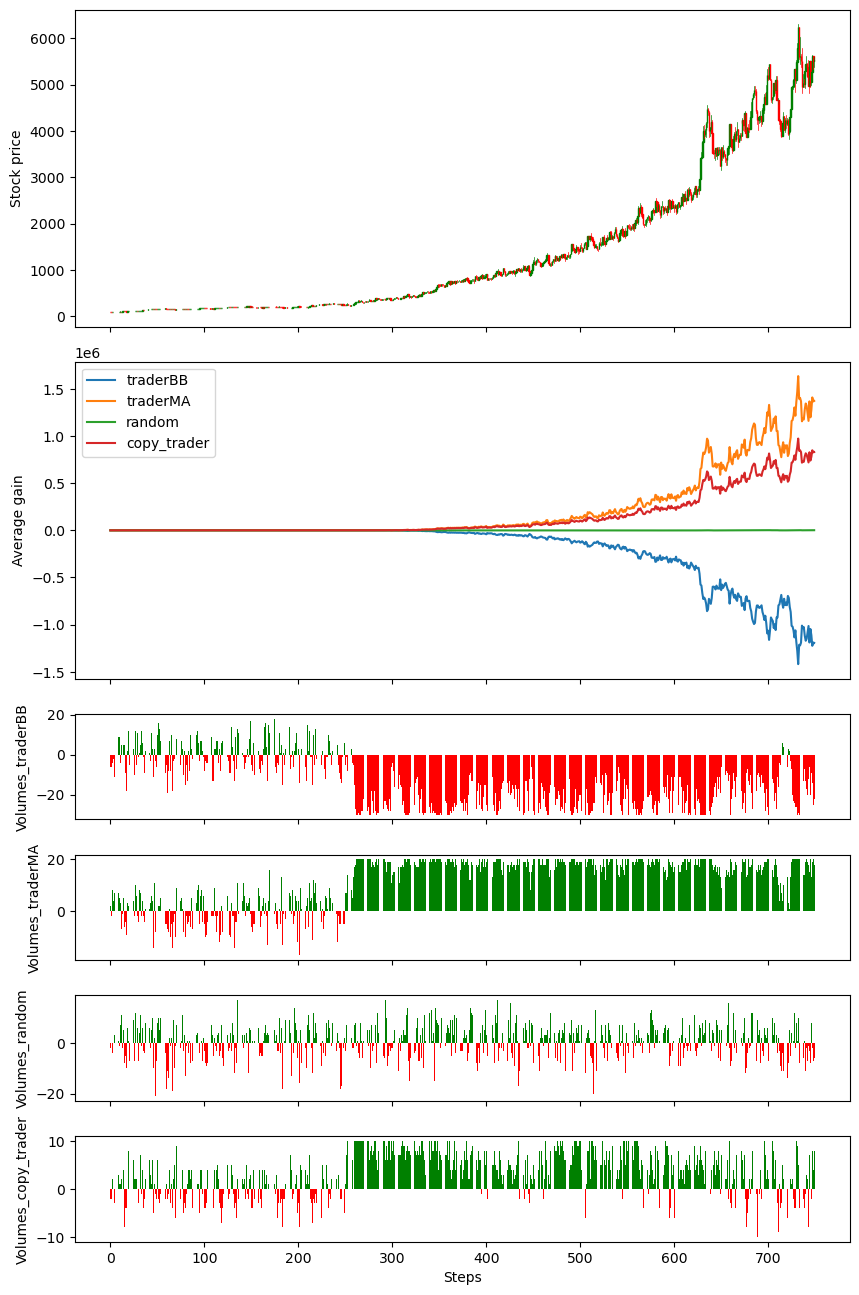

In [106]:
# PLOT STOCK AND VOLUMES ##

k = 2

agents_name = [
              'traderBB',
              'traderMA',
              'random',
              'copy_trader'
              ]

# Crea una figura e un oggetto axes
fig, axs = plt.subplots(len(agents_name)+2,
                        1, figsize = (10,16),
                        sharex=True,
                        gridspec_kw={'height_ratios': [3,3] + [1]*len(agents_name)})

# Utilizza la libreria candlestick_ohlc per creare il grafico a candela
candlestick_ohlc(axs[0], outs_simulation[k]['ohlc'], width=0.6, colorup='g', colordown='r')

for i,ag_name in enumerate(agents_name):
    
    axs[1].plot(outs_simulation[k][f'gain_{ag_name}'], label = ag_name)

    color = ['r' if x<0 else 'g' for x in outs_simulation[k][f'volume_{ag_name}']]
    
    axs[i+2].bar(np.arange(len(outs_simulation[k][f'volume_{ag_name}'])),
                 outs_simulation[k][f'volume_{ag_name}'],
                 color=color, label = ag_name)

    #axs[i+2].legend(loc=0)

    axs[i+2].set_ylabel(f'Volumes_{agents_name[i]}')

axs[1].legend(loc=0)

axs[len(agents_name)+1].set_xlabel('Steps')
axs[0].set_ylabel('Stock price')
axs[1].set_ylabel('Average gain')

#plt.savefig('stock_price_10_3_3.png')
plt.show()

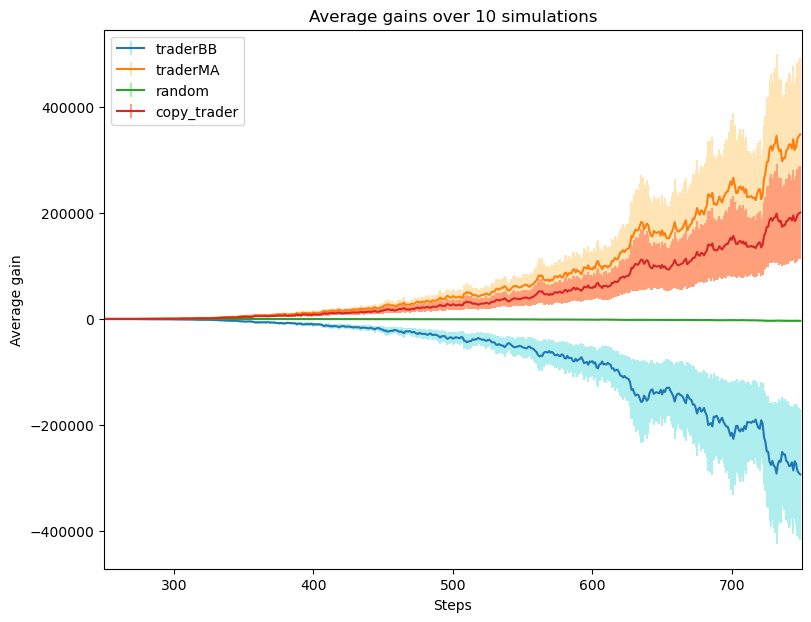

In [103]:
# PLOT AVG GAIN WITH VARIANCE ##

agents_name_plot = [
              'traderBB',
              'traderMA',
              'random',
              'copy_trader'
              ]

# dizionario del guadagno medio e deviazione standard sulle simulationi agente per agente {nome_agente: guadagno medio step by step}

avg_gain_agents = {f'avg_gain_{name}':np.array([np.array(d[f'gain_{name}']) for d in outs_simulation]).mean(axis=0) for name in agents_name}
std_gain_agents = {f'std_gain_{name}':np.array([np.array(d[f'gain_{name}']) for d in outs_simulation]).std(axis=0) for name in agents_name}

plt.figure(figsize=(9,7))
plt.xlabel('Steps')
plt.ylabel('Average gain')
plt.title('Average gains over 10 simulations')
colori = ['paleturquoise', 'moccasin', 'palegreen', 'lightsalmon']
for i,ag_name in enumerate(agents_name_plot):

    plt.errorbar(np.arange(n_step_init+n_step_simulation),
               avg_gain_agents[f'avg_gain_{ag_name}'],
               yerr= std_gain_agents[f'std_gain_{ag_name}']/np.sqrt(n_simulations),
#               yerr= std_gain_agents[f'std_gain_{ag_name}'],
               label = ag_name,
               ecolor = colori[i]
               )

plt.legend(loc=2)

plt.xlim(n_step_init, n_step_init + n_step_simulation )

#plt.grid()

plt.show()

/var/folders/w3/7mrtqn896yq5t06njsft4dj80000gn/T/ipykernel_3902/3852166419.py:1: RuntimeWarning: invalid value encountered in divide
  plt.plot(pd.Series((std_gain_agents['std_gain_traderMA']/np.sqrt(n_simulations)) / (std_gain_agents['std_gain_copy_trader']/np.sqrt(n_simulations))).dropna().loc[300:])


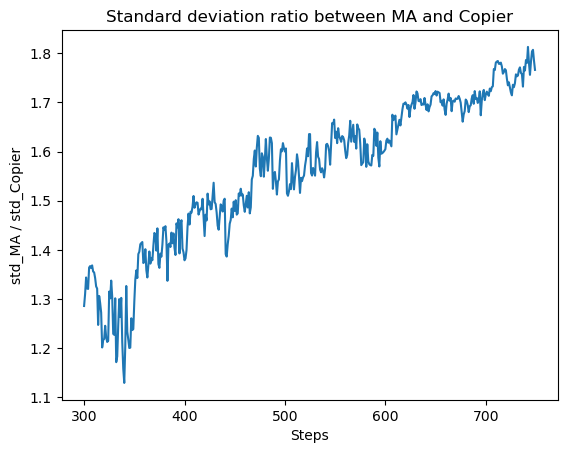

In [89]:
plt.plot(pd.Series((std_gain_agents['std_gain_traderMA']/np.sqrt(n_simulations)) / (std_gain_agents['std_gain_copy_trader']/np.sqrt(n_simulations))).dropna().loc[300:])
plt.xlabel('Steps')
plt.ylabel('std_MA / std_Copier')
plt.title('Standard deviation ratio between MA and Copier')
plt.show()



In [65]:
(std_gain_agents['std_gain_traderMA']/np.sqrt(n_simulations))[-1]

209927.36271215838

In [68]:
(std_gain_agents['std_gain_traderBB']/np.sqrt(n_simulations))[-1]

182426.90512460558

In [71]:
(std_gain_agents['std_gain_random']/np.sqrt(n_simulations))[-1]

2580.4592861860456

In [ ]:
## PLOT ##

# Crea una figura e un oggetto axes
fig, axs = plt.subplots(len(agents_name)+2, 1, figsize = (10,16), sharex=True, gridspec_kw={'height_ratios': [3,3] + [1]*len(agents_name)})

# Utilizza la libreria candlestick_ohlc per creare il grafico a candela
candlestick_ohlc(axs[0], out_simulation['ohlc'], width=0.6, colorup='g', colordown='r')


for i,ag_name in enumerate(agents_name):
  axs[1].plot(out_simulation[f'gain_{ag_name}'], label = ag_name)

  color = ['r' if x<0 else 'g' for x in out_simulation[f'volume_{ag_name}']]

  axs[i+2].bar(np.arange(len(out_simulation[f'volume_{ag_name}'])), out_simulation[f'volume_{ag_name}'],
               color=color, label = ag_name)

  axs[i+2].legend(loc=0)

axs[1].legend(loc=0)


axs[len(agents_name)+1].set_xlabel('Time')

plt.show()

# Simulazione originale

In [ ]:
# agents composition
N_random = 100
N_trader_MA = 50
N_trader_BB = 50

seed_init = 'random'
shuffle = False

# random params
gaussian_shift = 0.001
# ma params
min_period_ma=2
max_period_ma=7
## bb params
min_period_bb=2
max_period_bb=7
min_bb_dev=0.5
max_bb_dev=2


#simulation params
n_step_init = 100
n_step_simulation = 1000
initial_price = 100
verb = 0
seed_simu = 'random'

In [ ]:
## INIZIALIZZAZIONE AGENTI

agents, seed = initialize_agents(N_random, N_trader_MA, N_trader_BB,
                                  gaussian_shift = gaussian_shift,
                                  min_period_ma=min_period_ma, max_period_ma=max_period_ma,
                                  min_period_bb=min_period_bb, max_period_bb=max_period_bb,
                                  min_bb_dev=min_bb_dev, max_bb_dev=max_bb_dev,
                                  shuffle = shuffle, seed = seed_init)

## SIMULAZIONE ##

out_simulation = asmt_simulation(agents,
                                n_step_init = n_step_init,
                                n_step_simulation = n_step_simulation,
                                initial_price = initial_price,
                                verb = verb,
                                seed = seed_simu)

In [ ]:
## PLOT ##

# Crea una figura e un oggetto axes
fig, axs = plt.subplots(4,1, figsize = (10,12), sharex=True, gridspec_kw={'height_ratios': [2.5,2,1,1]})

# Utilizza la libreria candlestick_ohlc per creare il grafico a candela
candlestick_ohlc(axs[0], out_simulation['ohlc'], width=0.6, colorup='g', colordown='r')

axs[1].plot(out_simulation['gains_random'], label = 'random')
axs[1].plot(out_simulation['gains_ma'], label = 'ma')
axs[1].plot(out_simulation['gains_bb'], label = 'bb')
axs[1].legend(loc=0)

color_bb = ['r' if x<0 else 'g' for x in out_simulation['volumes_bb']]
axs[2].bar(np.arange(len(out_simulation['volumes_bb'])), out_simulation['volumes_bb'], color=color_bb, label = 'volumes BB')
axs[2].legend(loc=0)

color_ma = ['r' if x<0 else 'g' for x in out_simulation['volumes_ma']]
axs[3].bar(np.arange(len(out_simulation['volumes_ma'])), out_simulation['volumes_ma'], color=color_ma, label = 'volumes MA')
axs[3].legend(loc=0)

axs[3].set_xlabel('Time')
plt.show()

# Molteplici simulazioni

In [ ]:
# agents composition
N_random = 10
N_trader_MA = 5
N_trader_BB = 5
seed_init = 'random'
shuffle = False

# random params
gaussian_shift = 0.001
# ma params
min_period_ma=2
max_period_ma=7
## bb params
min_period_bb=2
max_period_bb=7
min_bb_dev=0.5
max_bb_dev=2


#simulation params
n_step_init = 200
n_step_simulation = 1000
initial_price = 100
verb = 0

n_simulations = 10
seed_simus = ['random']*n_simulations

# Roba vecchia che teniamo per ricordo

In [ ]:
## SIMULAZIONE ##

c=0   #contatore temporale
n_steps = 1000
price = 100
final_price = price
verb = 0

n_buy_ma = 0
n_sell_ma = 0
n_buy_bb = 0
n_sell_bb = 0

volumes_sell_bb = []
volumes_sell_ma = []
volumes_buy_bb = []
volumes_buy_ma = []

volumes_sell_bb.append(n_sell_bb)
volumes_sell_ma.append(n_sell_ma)
volumes_buy_bb.append(n_buy_bb)
volumes_buy_ma.append(n_buy_ma)

avg_gains_random = []
avg_gains_ma = []
avg_gains_bb = []

highs = []
lows = []
opens = []
closes = []


for k in tqdm(range(n_steps), position=0,leave=True):

  # la history OHLC fino ad ora zippata
  ohlc = list(zip(opens,highs,lows,closes))

  opens.append(price)
  high = price
  low = price

  c = 0     #contatore temporale per filling ordine resettato dopo ogni step
  np.random.shuffle(agents)     #shuffle indici agenti sennò i primi sono avvantaggiati perché agiscono sempre prima

  queueB=[] #bids
  queueS=[] #asks

  for i,agent in enumerate(agents):

    ## RANDOM AGENTS ##
    if(agent.tipo == 'Random'):

      decision = agent.Action()
      price_new = agent.Price(price, c)

      if(decision=='Buy'):
          queueB.append(price_new)
          queueB.sort()
          c+=1

      elif(decision=='Sell'):
          queueS.append(price_new)
          queueS.sort()
          c+=1

      if (decision in ['Buy','Sell']):
        printv(f'agente n. {i} id {agent.id} {agent.tipo} {decision} at {price_new[0]}',1,verb)
        printv(f'queueB:\n{queueB}\nqueueS:\n{queueS}',2,verb)

    ## TraderAgentMA ##
    if((agent.tipo == 'TraderMA') and (k > 200)): #gli AgentiMA e BB entrano nel mercato dopo 200 step in cui ci sono solo Random

      decision = agent.Action(ohlc, final_price)
      price_new = agent.Price(price, decision, c)

      if(decision=='Buy'):
          n_buy_ma += 1
          queueB.append(price_new)
          queueB.sort()
          c+=1

      elif(decision=='Sell'):
          n_sell_ma += 1
          queueS.append(price_new)
          queueS.sort()
          c+=1

      if (decision in ['Buy','Sell']):
        printv(f'agente {agent.id} {agent.tipo} {decision} at {price_new[0]}',1,verb)
        printv(f'queueB:\n{queueB}\nqueueS:\n{queueS}',2,verb)

    ## TraderAgentBB ##
    if ((agent.tipo == 'TraderBB') and (k > 200)):

      decision = agent.Action(ohlc, final_price)
      price_new = agent.Price(final_price, decision, c)

      if(decision=='Buy'):
          n_buy_bb += 1
          queueB.append(price_new)
          queueB.sort()
          c+=1

      elif(decision=='Sell'):
          n_sell_bb += 1
          queueS.append(price_new)
          queueS.sort()
          c+=1

      if (decision in ['Buy','Sell']):
        printv(f'agente {agent.id} {agent.tipo} {decision} at {price_new[0]}',1,verb)
        printv(f'queueB:\n{queueB}\nqueueS:\n{queueS}',2,verb)

    ## ORDERS MATCHING ##
    if(len(queueB)!=0 and len(queueS)!=0):

      # li ordino dal minore al maggiore
      queueB.sort()
      queueS.sort()
      printv(f'queueB:\n{queueB}\nqueueS:\n{queueS}',0,verb)
      # il più piccolo ask
      ask = queueS[0][0]
      bids = np.array(queueB)[:,0]

      # se c'è almeno un bid maggiore del più piccolo ask allora prendo il più piccolo ask
      if (bids > ask).sum() > 0:

        bid = bids[bids > ask][0]

        #agente buyer
        idx_buyer = np.arange(len(bids))[bids > ask][0]

        id_buyer = queueB[idx_buyer][1] # id dell'agente

        # si deve trovare l'indice di lista di agents ha id j_b
        j_b = [i for i,a in enumerate(agents) if a.id == id_buyer][0]

        time_buy = queueB[idx_buyer][2]

        #agente seller
        id_seller = queueS[0][1]
        j_s = [i for i,a in enumerate(agents) if a.id == id_seller][0]
        time_sell = queueS[0][2]

        if (time_sell > time_buy):  #se l'ordine di vendita viene immesso dopo quello di comprare, il prezzo finale è quello del bid
          final_price = bid
        else:
          final_price = ask #altrimenti è quello di ask

        #compra al prezzo di ask anche se ha chiesto di comprare al prezzo di bid più alto
        agents[j_b].cash -= final_price
        agents[j_b].stock += 1
        printv(f'agente n. {j_b} id {agents[j_b].id} {agents[j_b].tipo} cash {agents[j_b].cash} stock {agents[j_b].stock}',1,verb)

        # vende al prezzo di ask che ha detto lui (sempre il più basso)
        agents[j_s].cash += final_price
        agents[j_s].stock -= 1
        printv(f'agente n. {j_s} id {agents[j_s].id} {agents[j_s].tipo} cash {agents[j_s].cash} stock {agents[j_s].stock}',1,verb)

        printv(f'MATCHING: agente n. {j_b} id {agents[j_b].id} {agents[j_b].tipo} buy - agente n.{j_s} id {agents[j_s].id} {agents[j_s].tipo}  sell: at {final_price}',0,verb)

        queueB.remove(queueB[idx_buyer])
        queueS.remove(queueS[0])
        price = final_price

        # cerco massimi e minimi della candela
        if final_price > high:
          high = final_price
        if final_price < low:
          low = final_price

      # compute profit for each agents
      for i,agent in enumerate(agents):
          agent.gain = agent.cash + (final_price * agent.stock)
          printv(f'agente n. {i} id {agent.id} {agent.tipo} cash {agent.cash} stock {agent.stock} gain {agent.gain}',1,verb)

  # compute average profit at each timestep
  media_random = np.array([agent.gain for agent in agents if (agent.tipo == 'Random')]).mean()
  media_ma = np.array([agent.gain for agent in agents if (agent.tipo == 'TraderMA')]).mean()
  media_bb = np.array([agent.gain for agent in agents if (agent.tipo == 'TraderBB')]).mean()

  avg_gains_random.append(media_random)
  avg_gains_ma.append(media_ma)
  avg_gains_bb.append(media_bb)

  #Calcolo dei Volumi

  volumes_sell_bb.append(n_sell_bb - volumes_sell_bb[k])
  volumes_sell_ma.append(n_sell_ma - volumes_sell_ma[k])
  volumes_buy_bb.append(n_buy_bb - volumes_buy_bb[k])
  volumes_buy_ma.append(n_buy_ma - volumes_buy_ma[k])

  #Aggiornamento candela

  closes.append(price)
  highs.append(high)
  lows.append(low)


volumes_BB =  np.array(volumes_buy_bb) - np.array(volumes_sell_bb)
volumes_MA =  np.array(volumes_buy_ma) - np.array(volumes_sell_ma)

# # compute profit for each agents
# for i,agent in enumerate(agents):
#     agent.gain = agent.cash + (final_price * agent.stock)
#     printv(f'agente n. {i} id {agent.id} {agent.tipo} cash {agent.cash} stock {agent.stock} gain {agent.gain}',1,verb)





In [ ]:
df = pd.read_csv(file_name)

sample = len(df.drop_duplicates())

how_many_traders = 50
how_many_random = 50

min_period_bb_long = 7 #np.random.randint(25,100)
max_period_bb_long = 200 #np.random.randint(min_period_bb_long+1, 250)

min_bb_dev_long = 0.5 #np.random.uniform(0.25,1)
max_bb_dev_long = 2 #np.random.uniform(min_bb_dev_long+0.01, 4)

min_period_ma_long = 7 #np.random.randint(25,100)
max_period_ma_long = 200 #np.random.randint(min_period_ma_long+1, 250)

interval_pass = 0.1 #np.random.uniform(0.05,0.3) 


while True:
    
    # read csv
    df = pd.read_csv(file_name)

    traders_size = np.random.uniform(0,1,size=n_classes)
    traders_size = np.round((traders_size/traders_size.sum())*how_many_traders)
    traders_size[traders_size.argmax()] -= traders_size.sum() - how_many_traders
    traders_size = traders_size.astype(int)
    
    # cerca i duplicati 
    samples = df[[c for c in df.columns if (('how_many' in c) and (c != 'random_how_many')) ]].values
    if len(samples)==0:
        duplicate_flag = False
    else:
        duplicate_flag = (traders_size == samples).all(axis=1).any()

    while duplicate_flag:
        #print(f'ho trovato un dupicato {traders_size}\n')
        traders_size = np.random.uniform(0,1,size=n_classes)
        traders_size = np.round((traders_size/traders_size.sum())*how_many_traders)
        traders_size[traders_size.argmax()] -= traders_size.sum() - how_many_traders
        traders_size = traders_size.astype(int)
        duplicate_flag = (traders_size == samples).all(axis=1).any()
        


    agents_type_dic = {'traderBB':{'min_period_bb':min_period_bb_long,
                                         'max_period_bb':max_period_bb_long,
                                         'min_bb_dev':min_bb_dev_long,
                                         'max_bb_dev':max_bb_dev_long,
                                         'name':'traderBB',
                                         'type':TraderAgentBB,
                                         'how_many':traders_size[0],},
                       
                       'traderMA':{'min_period_ma':min_period_ma_long,
                                         'max_period_ma':max_period_ma_long,
                                         'name':'traderMA',
                                         'interval_pass':interval_pass,
                                         'type':TraderAgentMA,
                                         'how_many':traders_size[1],},

#                        'traderBB_dayT':{'min_period_bb':min_period_bb_day,
#                                          'max_period_bb':max_period_bb_day,
#                                          'min_bb_dev':min_bb_dev_day,
#                                          'max_bb_dev':max_bb_dev_day,
#                                         'name':'traderBB_dayT',
#                                         'type':TraderAgentBB,
#                                         'how_many':traders_size[2],
#                                         },

#                        'traderMA_dayT':{'min_period_ma':min_period_ma_day,
#                                          'max_period_ma':max_period_ma_day,
#                                         'name':'traderMA_dayT',
#                                         'interval_pass':interval_pass,
#                                         'type':TraderAgentMA,
#                                         'how_many':traders_size[3],},

                       'random':{'gaussian_shift':0.00053,
                                 'how_many': how_many_random,
                                 'name':'random',
                                 'type':RandomAgent},

#                        'copy_trader':{
#                                  'min_copied_agents':min_copied_agent,
#                                  'max_copied_agents':max_copied_agent,
#                                  'min_copied_period':min_copied_period,
#                                  'max_copied_period':max_copied_period,
#                                  'how_many':how_many_agents[4],
#                                  'name':'copy_trader',
#                                  'type':CopyAgent},
                       }


    # no shuffle agenti all'inizio
    shuffle = False

    #simulation params
    n_step_init = 250
    n_step_simulation = 500
    initial_price = 100
    verb = 0
    #seed_simu = 'random'

    n_simulations = 10
    seeds = ['random']*n_simulations

    outs_simulation = []

    for i,seed in tqdm(enumerate(seeds), position=0,leave=True, total = n_simulations, desc = f'{sample+1} sample - {traders_size}'):

      # initialize agents #
      agents = initialize_agents2(agents_type_dic, shuffle=shuffle)

      # print agents type frequency
      #print(pd.Series([a.name for a in agents]).value_counts(),'\n')
      agents_name = list(set([a.name for a in agents]))

      ## SIMULAZIONE ##

      out_simulation = asmt_simulation2(agents,
                                        n_step_init = n_step_init,
                                        n_step_simulation = n_step_simulation,
                                        initial_price = initial_price,
                                        verb = verb,
                                        seed = seed,
                                        tqdm_bar_desc = f'simu_{i}',
                                        tqdm_bar_on = False)

      outs_simulation.append(out_simulation)

    avg_gain_agents = {f'avg_gain_{name}':np.array([np.array(d[f'gain_{name}']) for d in outs_simulation]).mean(axis=0) for name in agents_name}
    std_gain_agents = {f'std_gain_{name}':np.array([np.array(d[f'gain_{name}']) for d in outs_simulation]).std(axis=0) for name in agents_name}
    seeds = [o['seed'] for o in outs_simulation]
    
    data = { 'n_sim': [n_simulations],
             'n_step_init': [n_step_init] ,
             'n_step_sim': [n_step_simulation],
             'seeds':[seeds],
                              }
    
    input_p = {}
    [input_p.update({f'{k}_{k1}':[v1] for k1,v1 in v.items()}) for k,v in agents_type_dic.items()]

    data.update(input_p)
    data.update({k:[list(v)] for k,v in avg_gain_agents.items()})
    data.update({k:[list(v)] for k,v in std_gain_agents.items()})

    # nuova riga da appendere al df
    df_new_row = pd.DataFrame(data)
    #appendo al df e salvo
    df = pd.concat([df, df_new_row], ignore_index = True)
    df.to_csv(file_name, index=False)
    
    sample += 1

In [ ]:
## FUNZIONE DI PRIMA ##

def initialize_agents(N_random, N_trader_MA, N_trader_BB,
                      gaussian_shift = 0.001,
                      min_period_ma=2, max_period_ma=7,
                      min_period_bb=2, max_period_bb=7,
                      min_bb_dev=0.5, max_bb_dev=2,
                      seed = 'random', shuffle = False):

  ## Agents creation ##

  agents=[]

  for i in range(N_random):
      A=RandomAgent(i,
                    gaussian_shift=gaussian_shift)
      agents.append(A)

  for i in range(N_trader_MA):
      A=TraderAgentMA(i+N_random,
                      min_period_ma=min_period_ma,
                      max_period_ma=max_period_ma)

      agents.append(A)

  for i in range(N_trader_BB):
      A=TraderAgentBB(i + N_trader_MA + N_random,
                      min_period_bb=min_period_bb,
                      max_period_bb=max_period_bb,
                      min_bb_dev=min_bb_dev,
                      max_bb_dev=max_bb_dev)

      agents.append(A)

  if seed == 'random':
    seed = np.random.randint(0,2**32)
  #set seed
  np.random.seed(seed)

  if shuffle:
    np.random.shuffle(agents)

  return agents, seed


#### FUNZIONE DELLA SIMULAZIONE ###

def asmt_simulation(agents,
                    n_step_init = 200,
                    n_step_simulation = 1000,
                    initial_price = 100,
                    verb = 0,
                    seed = 'random'):

  if seed == 'random':
    seed = np.random.randint(0,2**32)

  #set seed
  np.random.seed(seed)

  c=0   #contatore temporale

  price = initial_price
  final_price = initial_price

  volume_ma = 0
  volume_bb = 0
  volume_random = 0

  volumes_bb = []
  volumes_ma = []
  volumes_random = []

  volumes_bb.append(volume_bb)
  volumes_ma.append(volume_ma)
  volumes_random.append(volume_random)

  avg_gains_random = []
  avg_gains_ma = []
  avg_gains_bb = []

  highs = []
  lows = []
  opens = []
  closes = []


  for k in tqdm(range(n_step_simulation + n_step_init), position=0,leave=True):

    volume_ma = 0
    volume_bb = 0
    volume_random = 0

    # la history OHLC fino ad ora zippata
    ohlc = list(zip(opens,highs,lows,closes))

    opens.append(price)
    high = price
    low = price

    c = 0  #contatore temporale per filling ordine resettato dopo ogni step
    np.random.shuffle(agents) #shuffle indici agenti sennò i primi sono avvantaggiati perché agiscono sempre prima

    queueB=[] #bids
    queueS=[] #asks

    for i,agent in enumerate(agents):

      ## RANDOM AGENTS ##
      if(agent.tipo == 'Random'):

        decision = agent.Action()
        price_new = agent.Price(price, c)

        if(decision=='Buy'):
            queueB.append(price_new)
            queueB.sort()
            volume_random += 1
            c+=1

        elif(decision=='Sell'):
            queueS.append(price_new)
            queueS.sort()
            volume_random -= 1
            c+=1

        if (decision in ['Buy','Sell']):
          printv(f'agente n. {i} id {agent.id} {agent.tipo} {decision} at {price_new[0]}',1,verb)
          printv(f'queueB:\n{queueB}\nqueueS:\n{queueS}',2,verb)

      ## TraderAgentMA ##
      if((agent.tipo == 'TraderMA') and (k > n_step_init)): #gli AgentiMA e BB entrano nel mercato dopo 200 step in cui ci sono solo Random

        decision = agent.Action(ohlc, final_price)
        price_new = agent.Price(price, decision, c)

        if(decision=='Buy'):
            volume_ma += 1
            queueB.append(price_new)
            queueB.sort()
            c+=1

        elif(decision=='Sell'):
            volume_ma -= 1
            queueS.append(price_new)
            queueS.sort()
            c+=1

        if (decision in ['Buy','Sell']):
          printv(f'agente {agent.id} {agent.tipo} {decision} at {price_new[0]}',1,verb)
          printv(f'queueB:\n{queueB}\nqueueS:\n{queueS}',2,verb)

      ## TraderAgentBB ##
      if ((agent.tipo == 'TraderBB') and (k > n_step_init)):

        decision = agent.Action(ohlc, final_price)
        price_new = agent.Price(final_price, decision, c)

        if(decision=='Buy'):
            volume_bb += 1
            queueB.append(price_new)
            queueB.sort()
            c+=1

        elif(decision=='Sell'):
            volume_bb -= 1
            queueS.append(price_new)
            queueS.sort()
            c+=1

        if (decision in ['Buy','Sell']):
          printv(f'agente {agent.id} {agent.tipo} {decision} at {price_new[0]}',1,verb)
          printv(f'queueB:\n{queueB}\nqueueS:\n{queueS}',2,verb)

      ## ORDERS MATCHING ##
      if(len(queueB)!=0 and len(queueS)!=0):

        # li ordino dal minore al maggiore
        queueB.sort()
        queueS.sort()
        printv(f'queueB:\n{queueB}\nqueueS:\n{queueS}',0,verb)
        # il più piccolo ask
        ask = queueS[0][0]
        bids = np.array(queueB)[:,0]

        # se c'è almeno un bid maggiore del più piccolo ask allora prendo il più piccolo ask
        if (bids > ask).sum() > 0:

          bid = bids[bids > ask][0]

          #agente buyer
          idx_buyer = np.arange(len(bids))[bids > ask][0]

          id_buyer = queueB[idx_buyer][1] # id dell'agente

          # si deve trovare l'indice di lista di agents ha id j_b
          j_b = [i for i,a in enumerate(agents) if a.id == id_buyer][0]

          time_buy = queueB[idx_buyer][2]

          #agente seller
          id_seller = queueS[0][1]
          j_s = [i for i,a in enumerate(agents) if a.id == id_seller][0]
          time_sell = queueS[0][2]

          if (time_sell > time_buy):  #se l'ordine di vendita viene immesso dopo quello di comprare, il prezzo finale è quello del bid
            final_price = bid
          else:
            final_price = ask #altrimenti è quello di ask

          #compra al prezzo di ask anche se ha chiesto di comprare al prezzo di bid più alto
          agents[j_b].cash -= final_price
          agents[j_b].stock += 1
          printv(f'agente n. {j_b} id {agents[j_b].id} {agents[j_b].tipo} cash {agents[j_b].cash} stock {agents[j_b].stock}',1,verb)

          # vende al prezzo di ask che ha detto lui (sempre il più basso)
          agents[j_s].cash += final_price
          agents[j_s].stock -= 1
          printv(f'agente n. {j_s} id {agents[j_s].id} {agents[j_s].tipo} cash {agents[j_s].cash} stock {agents[j_s].stock}',1,verb)

          printv(f'MATCHING: agente n. {j_b} id {agents[j_b].id} {agents[j_b].tipo} buy - agente n.{j_s} id {agents[j_s].id} {agents[j_s].tipo}  sell: at {final_price}',0,verb)

          queueB.remove(queueB[idx_buyer])
          queueS.remove(queueS[0])
          price = final_price

          # cerco massimi e minimi della candela
          if final_price > high:
            high = final_price
          if final_price < low:
            low = final_price

        # compute profit for each agents
        for i,agent in enumerate(agents):
            agent.gain = agent.cash + (final_price * agent.stock)
            printv(f'agente n. {i} id {agent.id} {agent.tipo} cash {agent.cash} stock {agent.stock} gain {agent.gain}',1,verb)

    # compute average profit at each timestep
    media_random = np.array([agent.gain for agent in agents if (agent.tipo == 'Random')]).mean()
    media_ma = np.array([agent.gain for agent in agents if (agent.tipo == 'TraderMA')]).mean()
    media_bb = np.array([agent.gain for agent in agents if (agent.tipo == 'TraderBB')]).mean()

    avg_gains_random.append(media_random)
    avg_gains_ma.append(media_ma)
    avg_gains_bb.append(media_bb)

    #Aggiornamento dei Volumi

    volumes_bb.append(volume_bb)
    volumes_ma.append(volume_ma)
    volumes_random.append(volume_random)

    #Aggiornamento candela

    closes.append(price)
    highs.append(high)
    lows.append(low)

  ohlc = [(i, opens[i], highs[i], lows[i], closes[i]) for i in range(len(closes))]

  out = {'ohlc': ohlc,
         'volumes_bb': volumes_bb,
         'volumes_ma': volumes_ma,
         'volumes_random':volumes_random,
         'gains_random':avg_gains_random,
         'gains_bb':avg_gains_bb,
         'gains_ma':avg_gains_ma,
         'agents':agents,
         'seed':seed}

  return out